In [231]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import scipy.stats as scs
from statsmodels.stats.diagnostic import lilliefors
plt.rcParams['figure.max_open_warning'] = 50
%matplotlib agg

Ideja zadatka je analizirati razlike u školstvu u zemljama svijeta.
Podatke uzimam sa stranice http://data.un.org/. Prvo učitavam podatke.

In [232]:
data_popc = pd.read_csv('Population Growth Rates in Urban areas and Capital cities.csv', encoding='utf-8')
data_pop = pd.read_csv('Population Growth, Fertility and Mortality.csv', encoding='utf-8')
#data_gen = pd.read_csv('Population, Surface Area and Density.csv', encoding='utf-8')
data_edu = pd.read_csv('Public Expenditure on Education.csv', encoding='utf-8')
data_gdp = pd.read_csv('GDP and GDP Per Capita.csv', encoding='utf-8')

In [233]:
data_edu[data_edu['Series'] == 'Public expenditure on education (% of GDP)'].groupby(['Year']).size()

Year
2000     17
2001     13
2002     22
2003     16
2004     32
2005    113
2006     12
2007      9
2008     26
2009     27
2010    126
2011     14
2012     13
2013     23
2014     22
2015     60
2016     38
2017     55
2018      1
dtype: int64

In [234]:
for podaci in (data_popc, data_pop, data_edu, data_gdp):
    podaci.drop(podaci[podaci.Year < 2010].index, inplace=True)

In [235]:
print(data_popc['Series'].drop_duplicates().to_numpy())
print(data_pop['Series'].drop_duplicates().to_numpy())
print(data_edu['Series'].drop_duplicates().to_numpy())
print(data_gdp['Series'].drop_duplicates().to_numpy())

['Urban population (percent)'
 'Urban population (percent growth rate per annum)'
 'Rural population (percent growth rate per annum)'
 'Capital city population (thousands)'
 'Capital city population (as a percentage of total population)'
 'Capital city population (as a percentage of total urban population)']
['Population annual rate of increase (percent)'
 'Total fertility rate (children per women)'
 'Infant mortality for both sexes (per 1,000 live births)'
 'Maternal mortality ratio (deaths per 100,000 population)'
 'Life expectancy at birth for both sexes (years)'
 'Life expectancy at birth for males (years)'
 'Life expectancy at birth for females (years)']
['Current expenditure other than staff compensation as % of total expenditure in public institutions (%)'
 'All staff compensation as % of total expenditure in public institutions (%)'
 'Capital expenditure as % of total expenditure in public institutions (%)'
 'Expenditure by level of education: primary (as % of government expend

In [236]:
data_popc.drop(data_popc[data_popc.Series != 'Urban population (percent)'].index, inplace=True)
data_pop.drop(data_pop[data_pop.Series != 'Life expectancy at birth for both sexes (years)'].index, inplace = True)
data_gdp.drop(data_gdp[data_gdp.Series != 'GDP per capita (US dollars)'].index, inplace=True)

In [237]:
izbaci = data_edu.Series.isin(['Expenditure by level of education: primary (as % of government expenditure)',
                               'Expenditure by level of education: secondary (as % of government expenditure)',
                               'Expenditure by level of education: tertiary (as % of government expenditure)',
                               'Expenditure by level of education: pre-primary (as % of government expenditure)'
                              ])
data_edu.drop(data_edu[izbaci].index, inplace=True)

Pretvaram stupce s brojevima iz object u type float64.

In [238]:
data_popc['Value'] = data_popc['Value'].astype(str).astype(float)

In [239]:
data_gdp['Value'] = data_gdp['Value'].astype(str).str.replace(',', '').astype(float)

Sada grupiram vrijednosti po državama (to je stupac 'Unnamed: 1') i računam prosjek

In [240]:
a = data_popc.groupby('Unnamed: 1')['Value'].mean()
b = data_pop.groupby('Unnamed: 1')['Value'].mean()
c = data_edu.groupby(['Unnamed: 1', 'Series']).mean()
d = data_gdp.groupby('Unnamed: 1')['Value'].mean()

In [241]:
a.head()

Unnamed: 1
Afghanistan       24.666667
Albania           56.633333
Algeria           70.300000
American Samoa    87.333333
Andorra           88.400000
Name: Value, dtype: float64

In [242]:
c.reset_index(inplace=True)
c.Series.drop_duplicates().to_numpy()

array(['All staff compensation as % of total expenditure in public institutions (%)',
       'Capital expenditure as % of total expenditure in public institutions (%)',
       'Current expenditure other than staff compensation as % of total expenditure in public institutions (%)',
       'Public expenditure on education (% of GDP)',
       'Public expenditure on education (% of government expenditure)'],
      dtype=object)

In [243]:
c.set_index('Unnamed: 1', inplace=True)

In [244]:
c.head()

,Series,Region/Country/Area,Year,Value
Unnamed: 1,,,,
Afghanistan,All staff compensation as % of total expenditu...,4.0,2012.5,71.912700
Afghanistan,Capital expenditure as % of total expenditure ...,4.0,2012.5,18.955650
Afghanistan,Current expenditure other than staff compensat...,4.0,2012.5,9.131700
Afghanistan,Public expenditure on education (% of GDP),4.0,2014.0,3.543600
Afghanistan,Public expenditure on education (% of governme...,4.0,2014.0,15.079333


In [245]:
stupci = {'Urban (%)' : 'Urban population (percent)',
          'Life expectancy' :'Life expectancy at birth for both sexes (years)',
          'GDP per capita' : 'GDP per capita (US dollars)',
          'Exp on edu (% of GDP)' : 'Public expenditure on education (% of GDP)',
          'Exp on edu (% of gov exp)' : 'Public expenditure on education (% of government expenditure)',
          'Staff (% of total exp)' : 'All staff compensation as % of total expenditure in public institutions (%)',
          'Current exp (% of total exp)' : 'Current expenditure other than staff compensation\n as % of total expenditure in public institutions (%)',
          'Capital exp (% of total exp)' : 'Capital expenditure as % of total expenditure\n in public institutions (%)'
         }

In [246]:
data = pd.DataFrame({'Urban (%)' : a,
              'Life expectancy': b,
              'GDP per capita' : d,
              'Exp on edu (% of GDP)' : c[c.Series=='Public expenditure on education (% of GDP)']['Value'],
              'Exp on edu (% of gov exp)' : c[c.Series=='Public expenditure on education (% of government expenditure)']['Value'],
              'Staff (% of total exp)' : c[c.Series=='All staff compensation as % of total expenditure in public institutions (%)']['Value'],
              'Current exp (% of total exp)' : c[c.Series=='Current expenditure other than staff compensation as % of total expenditure in public institutions (%)']['Value'],
              'Capital exp (% of total exp)' : c[c.Series=='Capital expenditure as % of total expenditure in public institutions (%)']['Value']            
             })

In [247]:
data.head()

,Urban (%),Life expectancy,GDP per capita,Exp on edu (% of GDP),Exp on edu (% of gov exp),Staff (% of total exp),Current exp (% of total exp),Capital exp (% of total exp)
Afghanistan,24.666667,60.9765,593.00,3.5436,15.079333,71.9127,9.1317,18.95565
Albania,56.633333,76.5630,4115.50,3.6963,12.457350,76.0960,15.6955,8.20850
Algeria,70.300000,74.8410,4156.00,NaN,NaN,NaN,NaN,NaN
American Samoa,87.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Andorra,88.400000,NaN,38039.25,3.1265,NaN,36.0915,47.3752,1.20650


In [248]:
data.dropna(inplace=True)

Pogledajmo koje sve države imamo.

In [249]:
data.index.to_numpy()

array(['Afghanistan', 'Albania', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados',
       'Belarus', 'Belgium', 'Benin', 'Bhutan',
       'Bolivia (Plurin. State of)', 'Brazil', 'Brunei Darussalam',
       'Bulgaria', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon',
       'Canada', 'Chad', 'Colombia', 'Croatia', 'Cyprus', 'Czechia',
       'Côte d’Ivoire', 'Dem. Rep. of the Congo', 'Denmark',
       'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji',
       'Finland', 'France', 'Gambia', 'Germany', 'Ghana', 'Guatemala',
       'Guinea', 'Guinea-Bissau', 'Guyana', 'Honduras', 'Hungary',
       'Iceland', 'Indonesia', 'Iran (Islamic Republic of)', 'Ireland',
       'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan',
       'Kenya', 'Kyrgyzstan', "Lao People's Dem. Rep.", 'Latvia',
       'Lebanon', 'Lesotho', 'Lithuania', 'Luxembourg', 'Madagascar',
       'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta', 'Mexico'

### Analiza podataka

In [250]:
data.head()

,Urban (%),Life expectancy,GDP per capita,Exp on edu (% of GDP),Exp on edu (% of gov exp),Staff (% of total exp),Current exp (% of total exp),Capital exp (% of total exp)
Afghanistan,24.666667,60.9765,593.00,3.54360,15.079333,71.91270,9.1317,18.95565
Albania,56.633333,76.5630,4115.50,3.69630,12.457350,76.09600,15.6955,8.20850
Argentina,91.400000,75.2715,13063.25,5.29595,14.212250,84.14395,8.3430,7.51305
Armenia,63.200000,73.3635,3648.25,3.00355,11.298850,82.46800,8.2352,9.29680
Australia,85.633333,81.9195,55678.50,5.44050,14.201700,65.22720,27.1111,7.66170


In [251]:
data.describe()

,Urban (%),Life expectancy,GDP per capita,Exp on edu (% of GDP),Exp on edu (% of gov exp),Staff (% of total exp),Current exp (% of total exp),Capital exp (% of total exp)
count,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000
mean,57.636036,70.366694,15530.063063,4.533950,13.987847,68.524785,22.084718,9.559075
std,23.672273,9.396237,20736.855108,1.482636,4.023870,11.959667,11.231072,7.086279
min,11.900000,45.610500,268.750000,1.332700,2.014433,30.246300,0.876100,0.133300
25%,38.183333,63.852250,1401.750000,3.571600,11.312625,62.934275,15.611900,4.951483
50%,57.133333,73.404500,5694.500000,4.582533,13.471500,70.180650,21.125833,7.909800
75%,77.200000,77.893750,19322.125000,5.459050,16.201900,75.754150,26.826150,11.871000
max,98.833333,82.987000,103730.500000,8.229633,26.701350,98.710700,64.526900,42.460300


U svrhu crtanja histograma podataka zajedno sa grafom normalne razdiobe definiramo funkciju crtaj_histogram.

In [252]:
def crtaj_histogram(data, stupci={}):
    '''Funkcija prima DataFrame i crta histograme frekvencija svih stupaca zajedno sa funkcijom gustoce normalne razdiobe.
    Dodatni (opcionalni) parametar stupci je dictionary kojim se mogu zadavati imena histograma različita od imena stupaca u tablici.
    Ako je parametar stupci prazan rijecnik, onda su imena histograma imena stupaca u tablici.'''
    
    test = lambda br_stupaca : int(br_stupaca/2)+1 if br_stupaca % 2 else int(br_stupaca/2)
    m = test(len(data.columns)) #Broj redaka u subplots
    
    hist, ax = plt.subplots(m, 2, figsize=(15,15))
    hist.tight_layout(pad=4.0)
    j=0
    for row in ax:
        for axis in row:
            if (j<len(data.columns)):
                axis.hist(data.iloc[:,j], density=True, ec = 'black')
                
                mu, sigma = data.iloc[:,j].mean(), data.iloc[:,j].std()
                x = np.linspace(mu - 3*sigma, mu+3*sigma) #znamo da je u normalnoj distribuciji preko 99% podataka na udaljenosti manjoj od 3*std
                y = scs.norm.pdf(x, mu, sigma)
                axis.plot(x, y, color='red', lw=1.4)
                
                if not bool(stupci): #ako je dict prazan, ispisujem imena stupaca
                    axis.set_title(data.columns[j])
                else: #inace koristi dict   
                    axis.set_title(stupci[data.columns[j]])
                axis.set_ylabel('Frequency')
                axis.set_xlabel('')
            else:
                axis.remove()
            j+=1
    return hist

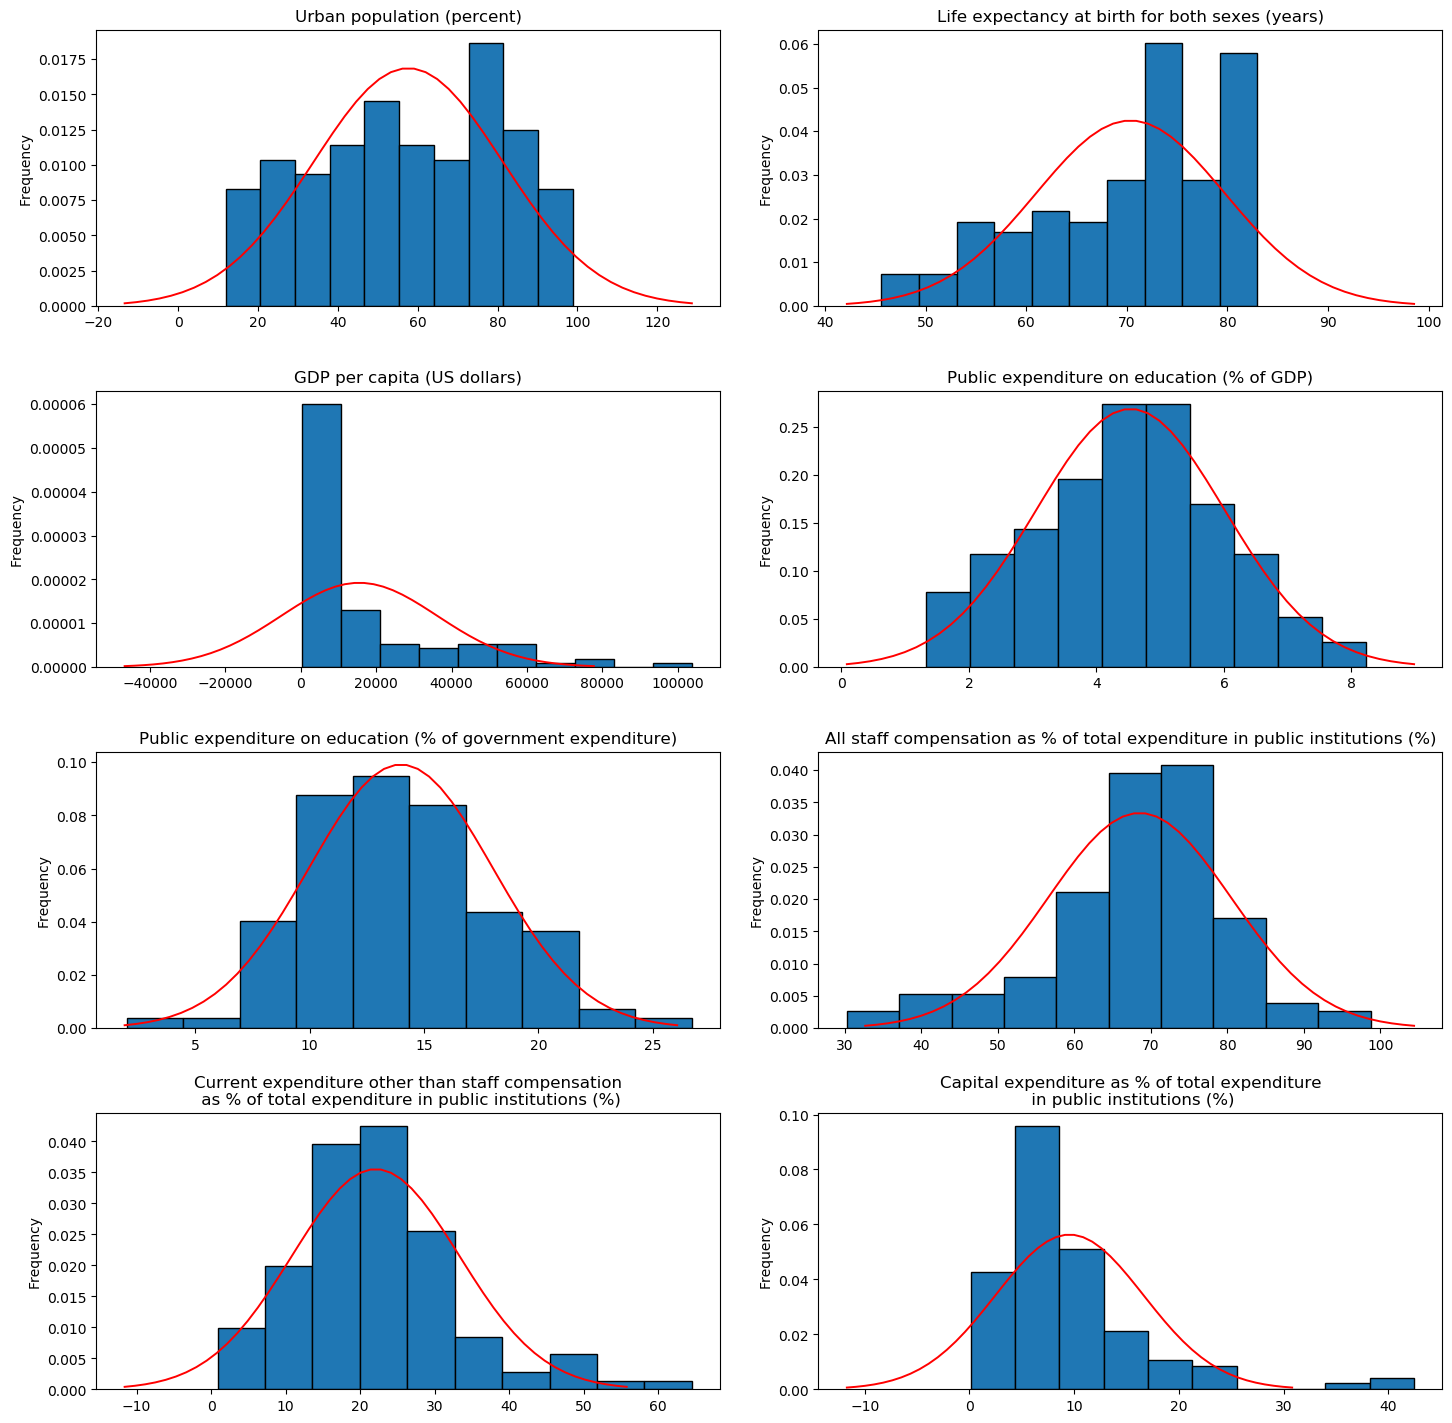

In [253]:
crtaj_histogram(data, stupci)

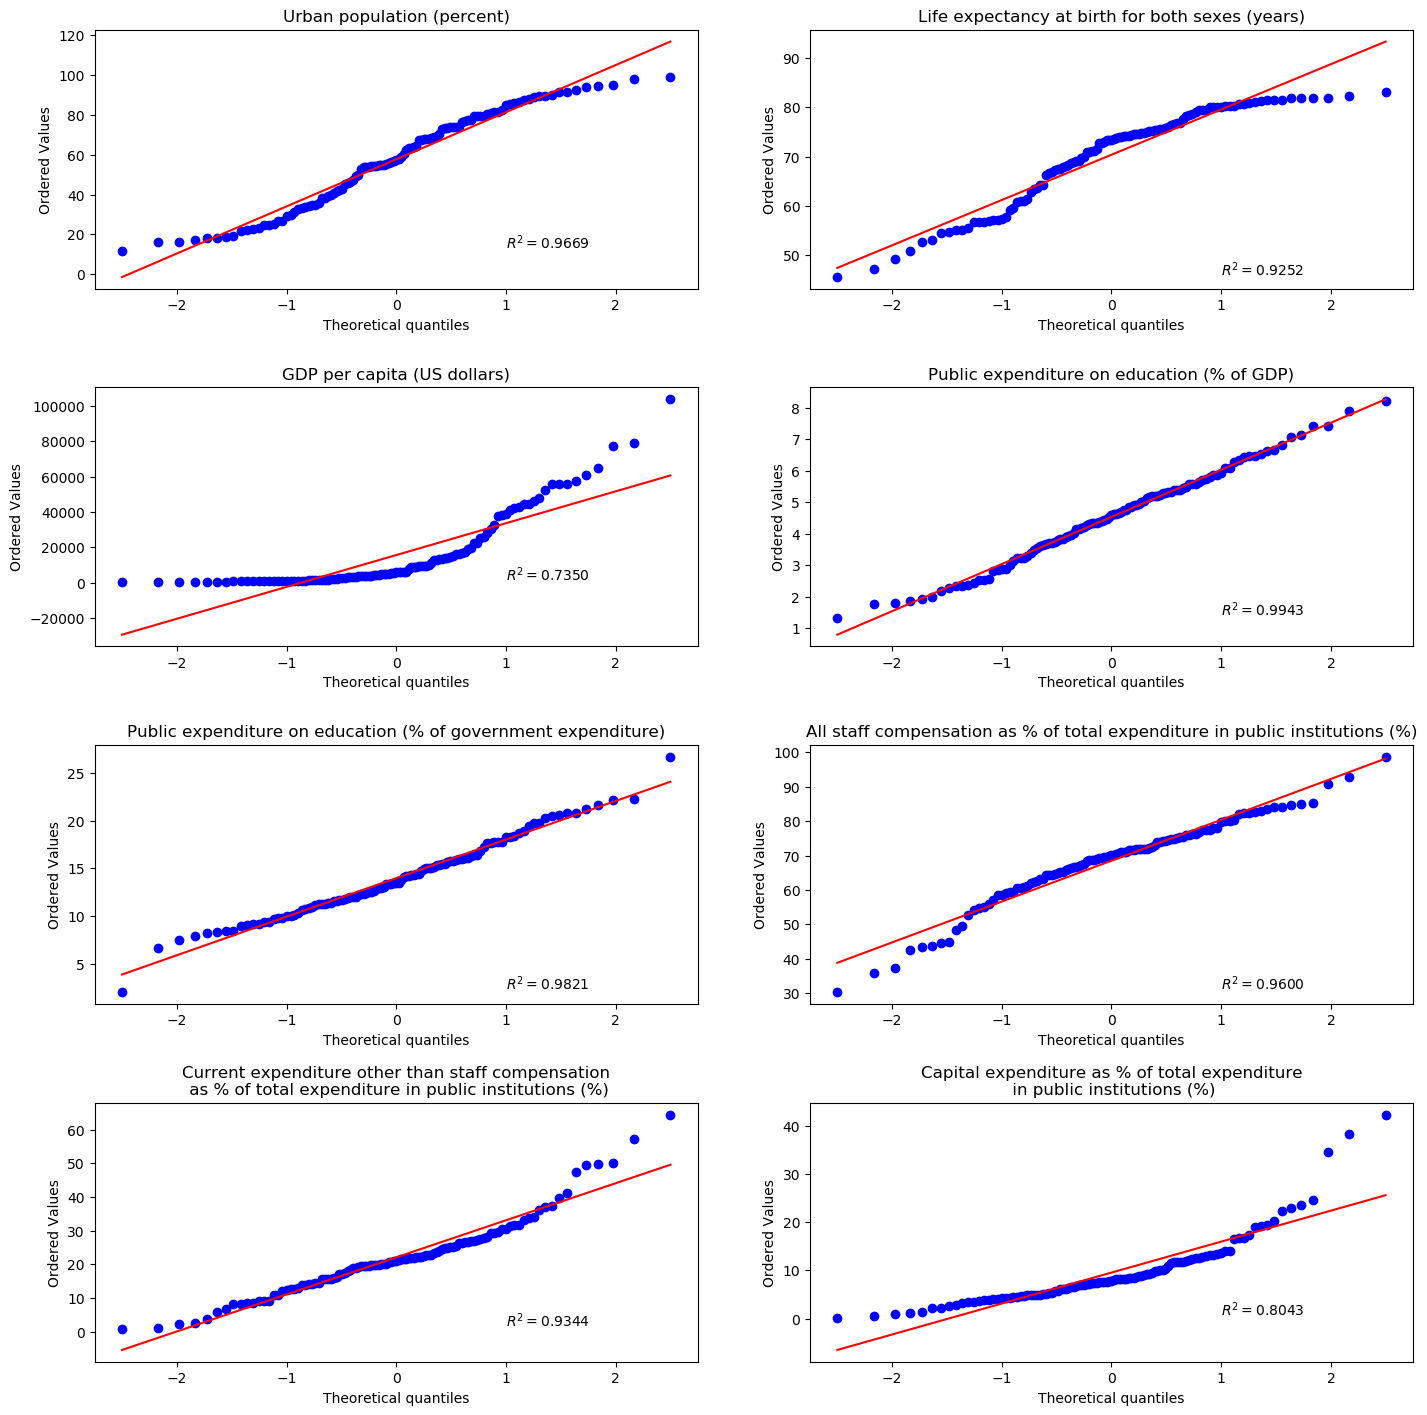

In [254]:
def crtaj_norm_vjer_graf(data, stupci={}):
    
    test = lambda br_stupaca : int(br_stupaca/2)+1 if br_stupaca % 2 else int(br_stupaca/2)
    m = test(len(data.columns)) #Broj redaka u subplots
    
    fig, ax = plt.subplots(m, 2, figsize=(15,15))
    fig.tight_layout(pad=5.0)
    j=0
    for row in ax:
        for axis in row:
            if (j<len(data.columns)):
                stats.probplot(data.iloc[:,j], plot=axis, rvalue=True, dist='norm')
                if not bool(stupci):
                    axis.set_title(data.columns[j])
                else:   
                    axis.set_title(stupci[data.columns[j]])
            else:
                axis.remove()
            j+=1
    return fig
crtaj_norm_vjer_graf(data,stupci)

In [255]:
def testovi_normalnosti(data):
    rez = pd.DataFrame(column=data.columns)
    #zavrsi funkciju za ljepsi ispis
    
for stupac in data.columns:
    print(stupac)
    print([round(i, 4) for i in lilliefors(data[stupac], dist='norm', pvalmethod='table')])
    print([round(i,4) for i in stats.normaltest(data[stupac])])
    print([round(i,4) for i in stats.shapiro(data[stupac])])
    print()

Urban (%)
[0.0837, 0.0652]
[25.3696, 0.0]
[0.9593, 0.0019]

Life expectancy
[0.153, 0.001]
[10.3076, 0.0058]
[0.9199, 0.0]

GDP per capita
[0.2309, 0.001]
[48.4706, 0.0]
[0.7368, 0.0]

Exp on edu (% of GDP)
[0.0426, 0.9126]
[0.9639, 0.6176]
[0.9912, 0.6993]

Exp on edu (% of gov exp)
[0.0611, 0.4285]
[2.6187, 0.27]
[0.9858, 0.2909]

Staff (% of total exp)
[0.0951, 0.0202]
[11.8073, 0.0027]
[0.9629, 0.0035]

Current exp (% of total exp)
[0.1069, 0.0045]
[24.2954, 0.0]
[0.9376, 0.0001]

Capital exp (% of total exp)
[0.1584, 0.001]
[66.7446, 0.0]
[0.8104, 0.0]



Iz testova normalnosti ne odbacujem pretpostavku da podaci dolaze iz normalno distribuiranih populacija za Exp on edu (% of GDP) i Exp on edu (% of gov exp). Urban (%), Current exp (% of total exp) i Capital exp (% of total exp) prema testovima nisu normalno distribuirani ali njihovi histogrami pokazuju da nisu daleko od normalnih distribucija. Za ostale podatke niti ne očekujemo da će biti normalno distribuirani.

### Koeficijenti korelacije

Sada računam koeficijente korelacije između parova podataka danih u tablici.
Prvo računam Pearsonov koeficijent korelacije i testiram hipotezu $H_0: \rho = 0$ nasuprot hipotezi $H_1: \rho \neq 0$.
Za testiranje Pearsonovog koeficijenta nužna je pretpostavka o normalnosti podataka. Zato za provjeru računam i Spearsonov koeficijent jer analogan test [ne zahtjeva](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.spearmanr.html) pretpostavku o normalnosti. Pearsonov koeficijent korelacije pokazuje stupanj linearnog odnosa između podataka, a Spearmanov koeficijent stupanje monotone povezanosti podataka ([izvor](https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/a-comparison-of-the-pearson-and-spearman-correlation-methods/)).


In [256]:
def korelacija(data, metoda):
    '''Funkcija računa matricu koeficijenata korelacija nad svim kombinacijama stupaca matrica.
    Koeficijenti koji su značajni označeni su s ***. Argumenti funkcije su DataFrame podataka i string koju metodu koristim'''
    if metoda not in {'pearson','spearman'}:
        raise ValueError("argument mora biti 'pearson' ili 'spearman'")
    cor = data.corr(method=metoda)
    for i in data.columns:
        for j in data.columns:
            if metoda == 'pearson':
                ro, pvalue = stats.pearsonr(data[i], data[j])
            else:
                ro, pvalue = stats.spearmanr(data[i], data[j])
            if i == j:
                cor.loc[i,j] = ''
            elif pvalue < 0.05:
                cor.loc[i,j] = '***%.4f' % (cor.loc[i,j])
            else:
                cor.loc[i,j] = '%.4f' % (cor.loc[i,j])
    return cor

In [257]:
korelacija(data, 'pearson')

,Urban (%),Life expectancy,GDP per capita,Exp on edu (% of GDP),Exp on edu (% of gov exp),Staff (% of total exp),Current exp (% of total exp),Capital exp (% of total exp)
Urban (%),,***0.7165,***0.6275,***0.3198,-0.1739,***0.2517,-0.1748,-0.1391
Life expectancy,***0.7165,,***0.6548,***0.2799,***-0.2898,0.0633,0.0563,***-0.1967
GDP per capita,***0.6275,***0.6548,,***0.3502,***-0.2463,0.0622,-0.0153,-0.0930
Exp on edu (% of GDP),***0.3198,***0.2799,***0.3502,,***0.4563,0.0594,0.0286,-0.1844
Exp on edu (% of gov exp),-0.1739,***-0.2898,***-0.2463,***0.4563,,-0.0182,-0.0430,0.0513
Staff (% of total exp),***0.2517,0.0633,0.0622,0.0594,-0.0182,,***-0.8119,***-0.3772
Current exp (% of total exp),-0.1748,0.0563,-0.0153,0.0286,-0.0430,***-0.8119,,***-0.2173
Capital exp (% of total exp),-0.1391,***-0.1967,-0.0930,-0.1844,0.0513,***-0.3772,***-0.2173,


In [258]:
korelacija(data, 'spearman')

,Urban (%),Life expectancy,GDP per capita,Exp on edu (% of GDP),Exp on edu (% of gov exp),Staff (% of total exp),Current exp (% of total exp),Capital exp (% of total exp)
Urban (%),,***0.7382,***0.8013,***0.3028,-0.1806,***0.2159,-0.1497,-0.0594
Life expectancy,***0.7382,,***0.8987,***0.3176,***-0.3203,0.0772,0.0260,-0.0574
GDP per capita,***0.8013,***0.8987,,***0.3694,***-0.3484,0.0431,0.0823,-0.1203
Exp on edu (% of GDP),***0.3028,***0.3176,***0.3694,,***0.4500,0.0333,0.0647,-0.1141
Exp on edu (% of gov exp),-0.1806,***-0.3203,***-0.3484,***0.4500,,0.0419,-0.0406,-0.0296
Staff (% of total exp),***0.2159,0.0772,0.0431,0.0333,0.0419,,***-0.7731,***-0.3555
Current exp (% of total exp),-0.1497,0.0260,0.0823,0.0647,-0.0406,***-0.7731,,-0.1500
Capital exp (% of total exp),-0.0594,-0.0574,-0.1203,-0.1141,-0.0296,***-0.3555,-0.1500,


Vidim da se zaključci o koreliranosti podataka razlikuju za dva slučaja: Capital exp (% of total exp) u odnosu na Life expectancy i Capital exp (% of total exp) u odnosu na Current exp (% of total exp). To su upravo slučajevi kada podaci odstupaju od normalnosti.

Nisu svi odnosi u tablici zanimljivi. Očito je da će npr. Staff (% of total exp) i Current exp (% of total exp) biti negativno korelirani jer se radi o postocima istog iznosa.
Međutim, uočavamo nepostojanje koreliranosti zadnja tri retka tablice s ostalim pokazateljima razvijenosti kao što su BDP per capita, očekivano trajanje života ili postotak gradskog stanovništva.
Prikažimo to u dijagramima raspršenja.

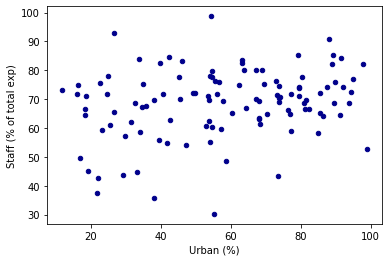

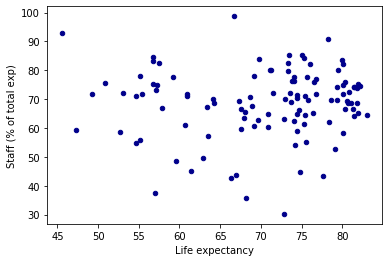

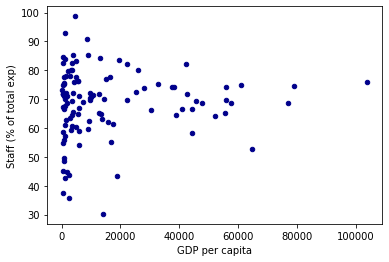

In [259]:
%matplotlib inline
s1=['Urban (%)', 'Life expectancy', 'GDP per capita']
for i in range(len(s1)):
    data.plot.scatter(s1[i], 'Staff (% of total exp)', c='darkblue')

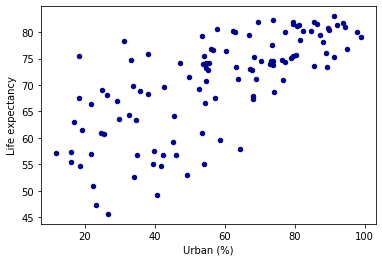

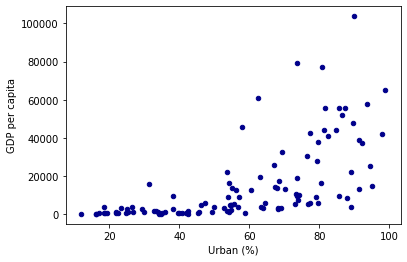

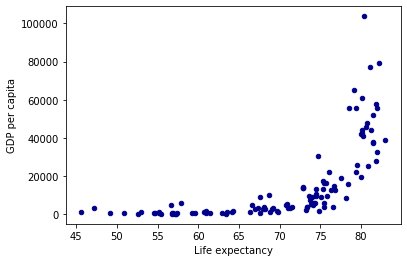

In [260]:
L = ['Urban (%)', 'Life expectancy', 'GDP per capita']
for i in range(len(L)):
    for j in range(i+1, len(L)):
        data.plot.scatter(L[i], L[j], c='darkblue') 

U ova tri slučaja podaci su jako korelirani. U slučaju odnosa BDP per capita i očekivanja trajanja života imamo klasičan primjer kada je odnos monoton (rastući) ali nije linearan. U tom slučaju se ne vidi taj odnos iz Pearsonovog koeficijenta korelacije koji iznosi 0.6548, ali je zato Spearmanov koeficijent korelacije jednak 0.8987.

U interpreataciji rezultata važno je prisjetiti se da korelacija [ne implicira](https://www.mathtutordvd.com/public/Why-Correlation-does-not-Imply-Causation-in-Statistics.cfm) kauzalnost (uzročnost). Pogledajmo to na primjeru korelacije postotka gradskog stanovništva i duljine života. Ljudi (najvjerojatnije) ne žive u prosjeku dulje jer žive u gradovima niti duljina života ne rezultira preseljenjem sa sela u grad, već postoji neki drugi faktor (npr. razvijenost zemlje) koji implicira poklapanje ova dva faktora. S druge strane, korelacija može ukazivati na uzročnost. U primjeru BDP-a per capita i duljine života, moguće je da zahvaljujući većem bogatstvu države, bolji zdravstveni sustav produljuje životni vijek stanovništva. Zato su potrebne dodatne analize prije nego što se donosi zaključak. [Ovdje](http://www.tylervigen.com/spurious-correlations) se mogu pronaći zanimljivi primjeri korelacija koji su rezultat slučajnosti.

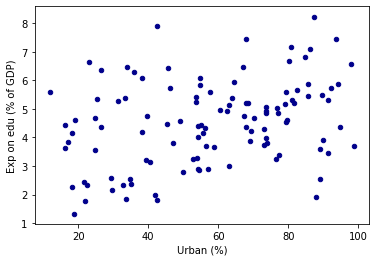

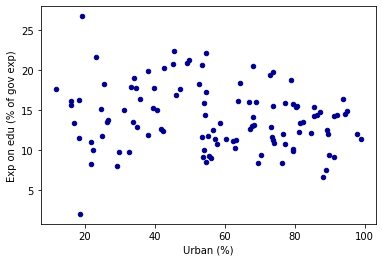

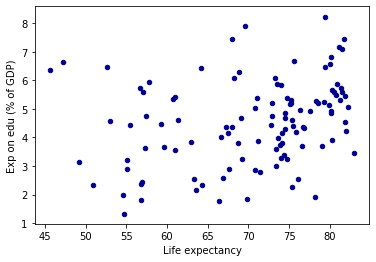

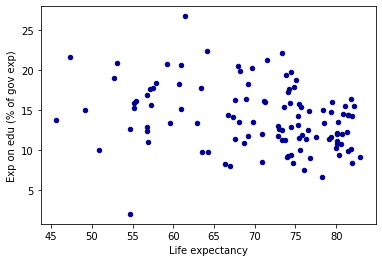

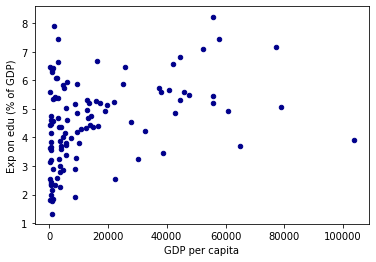

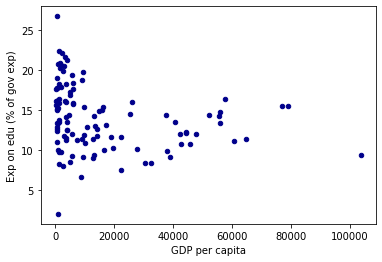

In [261]:
L = ['Urban (%)', 'Life expectancy', 'GDP per capita']
for i in range(len(L)):
    data.plot.scatter(L[i], 'Exp on edu (% of GDP)', c='darkblue') 
    data.plot.scatter(L[i], 'Exp on edu (% of gov exp)', c='darkblue') 

Vidimo da je potrošnja na obrazovanje kao postotka BDP-a slabo pozitivno korelirana (koeficijent korelacije je oko 0.3) s pokazateljima razvijenosti zemlje (BDP per capita, duljina trajanja života, postotak gradskog stanovništva). S druge strane, potrošnja na obrazovanje kao postotka od ukupne potrošnje je slabo negativno korelirana s pokazateljima razvijenosti.

Ovi pokazatelji potrošnje na obrazovanje imaju određena ograničena (vidjeti [ovdje](http://uis.unesco.org/en/glossary-term/expenditure-education-total-government-expenditure-all-sectors) i [ovdje](http://uis.unesco.org/en/glossary-term/government-expenditure-educational-institutions-gdp)): podaci se za neke zemlje odnose samo na Ministarstvo obrazovanja a ne na druga ministarstva koja mogu financirati obrazovanje, također u nekim zemljama je važan udio financiranja obrazovanja iz privatnog sektora pa zato udio financiranja iz javnog sektora može izgledati manji u odnosu na druge zemlje. Za potrebe ovog rada smatramo da su podaci najtočniji mogući jer dolaze od službenih organizacija.

Nadalje, zemlje s većim udjelom mladog stanovništva moraju trošiti više novca na obrazovanje u odnosu na zemlje koje imaju starije stanovništvo.


import seaborn as sns sns.set_style(style='white') sns.pairplot(data[['Urban (%)', 'Life expectancy', 'GDP per capita', 'Exp on edu (% of GDP)', 'Exp on edu (% of gov exp)']]);
moze se ovo koristiti?????